In [1]:
%matplotlib inline

import os
import statistics
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
from sklearn.metrics import average_precision_score, confusion_matrix, roc_auc_score

import torch
from torch.utils.data import DataLoader

import constants
from dataset import OctRandomSliceDataset
from model2d import SimpleSliceNet

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
def evaluate(net, loader, verbose=True):
    start = time.time()
    all_logits = []
    all_labels = []
    all_losses = []

    with torch.no_grad():
        for i, (X, y) in enumerate(loader):
            logits = net(X.to(device))
            loss = net.loss_fn(logits, y.to(device))
            all_logits.extend(list(logits.cpu().numpy()))
            all_labels.extend(list(y))
            all_losses.append(loss.item())

    val_loss = statistics.mean(all_losses)
    auprc = average_precision_score(all_labels, all_logits)
    auroc = roc_auc_score(all_labels, all_logits)
    
    if verbose:
        print(f'Average precision score: {auprc}')
        print(f'AUROC: {auroc}')
        print(f'Validation loss (approximate): {val_loss}')
        print(f'Elapsed: {time.time() - start}')
    return val_loss, auprc, auroc

In [4]:
cubes_path = os.path.join(constants.PROCESSED_DATA_PATH, constants.CUBES_FOLDER)

train_dir = os.path.join(cubes_path, 'train')
val_dir = os.path.join(cubes_path, 'val')
test_dir = os.path.join(cubes_path, 'test')

def train_with_slice(slice_idx, num_epochs=10, verbose=True):
    print('==============')
    print(f'Training with slice index: {slice_idx}')
    
    train_dataset = OctRandomSliceDataset(train_dir, slice_min=slice_idx, slice_max=slice_idx)
    val_dataset = OctRandomSliceDataset(val_dir, slice_min=slice_idx, slice_max=slice_idx)
    test_dataset = OctRandomSliceDataset(test_dir, slice_min=slice_idx, slice_max=slice_idx)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=8)

    net = SimpleSliceNet().to(device)

    if verbose: print('------ Evaluating ------')
    evaluate(net, val_loader, verbose)
    for epoch in range(1, num_epochs + 1):
        if verbose: print(f'====== Epoch {epoch} ======')
        losses = []
        for X, y in train_loader:
            loss = net.train_step(X.to(device), y.to(device))
            loss = loss.item()
            losses.append(loss)
        train_loss = statistics.mean(losses)
        if verbose: print(f'Train loss (approximate): {train_loss}')

        if verbose: print('------ Evaluating ------')
        val_loss, auprc, auroc = evaluate(net, val_loader, verbose)
        
    return train_loss, val_loss, auprc, auroc

In [5]:
slice_idxs = [0, 25, 50, 75, 100, 125, 150, 175, 199]
train_losses = []
val_losses = []
auprcs = []
aurocs = []

for slice_idx in slice_idxs:
    train_loss, val_loss, auprc, auroc = train_with_slice(slice_idx)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    auprcs.append(auprc)
    aurocs.append(auroc)

Training with slice index: 0
Number of cubes: 964
Number of cubes: 142
Number of cubes: 207
------ Evaluating ------
Average precision score: 0.45184390734980695
AUROC: 0.44133412745681955
Validation loss (approximate): 0.7169621189435323
Elapsed: 56.51134729385376
====== Epoch 1 ======
Train loss (approximate): 0.7761566732540603
------ Evaluating ------
Average precision score: 0.5496380079374719
AUROC: 0.5318642048838593
Validation loss (approximate): 0.78846808274587
Elapsed: 1.2898619174957275
====== Epoch 2 ======
Train loss (approximate): 0.7471585177685603
------ Evaluating ------
Average precision score: 0.5120470752960857
AUROC: 0.5072463768115942
Validation loss (approximate): 0.7564438548352983
Elapsed: 1.397092342376709
====== Epoch 3 ======
Train loss (approximate): 0.667867142799472
------ Evaluating ------
Average precision score: 0.5264077292755658
AUROC: 0.5396069088743299
Validation loss (approximate): 0.7243038415908813
Elapsed: 1.3786864280700684
====== Epoch 4 ===

Train loss (approximate): 0.7465779810897575
------ Evaluating ------
Average precision score: 0.603292335150413
AUROC: 0.6130633313480247
Validation loss (approximate): 0.6760608653227488
Elapsed: 1.3758635520935059
====== Epoch 2 ======
Train loss (approximate): 0.6894244571362645
------ Evaluating ------
Average precision score: 0.621491433740073
AUROC: 0.5812983918999405
Validation loss (approximate): 0.723895294798745
Elapsed: 1.5764636993408203
====== Epoch 3 ======
Train loss (approximate): 0.6498328343895842
------ Evaluating ------
Average precision score: 0.6587891367559905
AUROC: 0.6632916418503078
Validation loss (approximate): 0.731741898589664
Elapsed: 1.5852727890014648
====== Epoch 4 ======
Train loss (approximate): 0.6173196021190359
------ Evaluating ------
Average precision score: 0.6206652574102793
AUROC: 0.6241810601548541
Validation loss (approximate): 0.7071479691399468
Elapsed: 1.5318024158477783
====== Epoch 5 ======
Train loss (approximate): 0.5789573919181982

Train loss (approximate): 0.6951556678645867
------ Evaluating ------
Average precision score: 0.45101004978052095
AUROC: 0.4270399047051817
Validation loss (approximate): 0.7904251747661166
Elapsed: 1.4850659370422363
====== Epoch 3 ======
Train loss (approximate): 0.717943756787245
------ Evaluating ------
Average precision score: 0.49290212926847615
AUROC: 0.48123883263847533
Validation loss (approximate): 0.7680178549554613
Elapsed: 1.5977849960327148
====== Epoch 4 ======
Train loss (approximate): 0.673553316307462
------ Evaluating ------
Average precision score: 0.45964198023867364
AUROC: 0.4264443120905301
Validation loss (approximate): 0.8236276639832391
Elapsed: 1.5303325653076172
====== Epoch 5 ======
Train loss (approximate): 0.6322224457894475
------ Evaluating ------
Average precision score: 0.47953461181470586
AUROC: 0.48044470915227316
Validation loss (approximate): 0.887747740579976
Elapsed: 1.4432613849639893
====== Epoch 6 ======
Train loss (approximate): 0.621812463

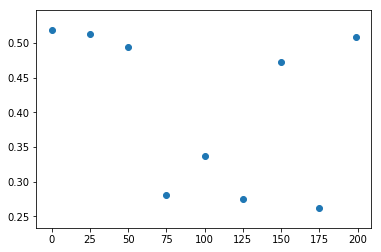

In [6]:
plt.scatter(slice_idxs, train_losses)

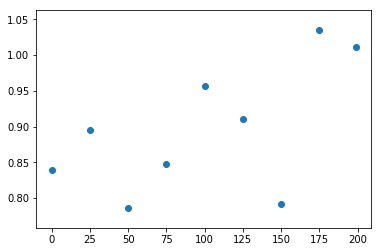

In [7]:
plt.scatter(slice_idxs, val_losses)

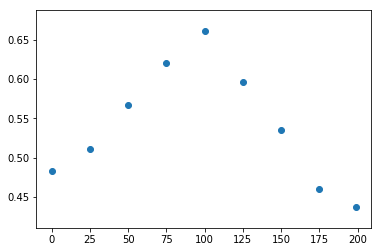

In [8]:
plt.scatter(slice_idxs, auprcs)

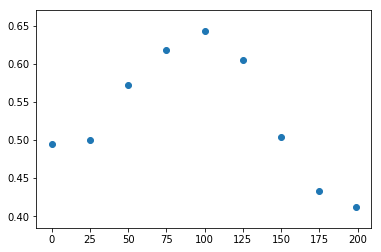

In [9]:
plt.scatter(slice_idxs, aurocs)